In [696]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import lasagne
import os
from lasagne.layers import *
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy.stats as st
import scipy
import seaborn as sns
%matplotlib inline

In [697]:
def data_generation(size_0):
    X = np.random.uniform(-1.0,1.0,size_0) + np.random.normal(0, 0.1, size_0)
    Y = np.sqrt(3 - np.multiply(X, X))  + np.random.normal(0, 0.2, size_0) + np.random.normal(-1, 0, size_0)
    X = X + np.random.normal(0, 0.1, size_0) + np.random.normal(-1, 0, size_0)
    return X, Y


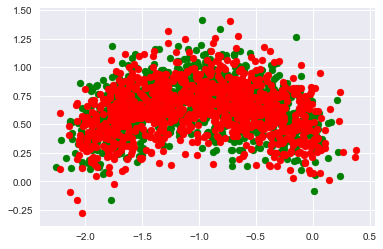

In [698]:
X, Y = data_generation(size_0=1000)
X_noise,Y_noise = data_generation(size_0=1000)
plt.scatter(X, Y, color = "green")
plt.scatter(X_noise, Y_noise, color = "red")

In [699]:
data = np.column_stack((X, Y))
noise = np.column_stack((X_noise, Y_noise))
print(data.shape)
print(noise.shape)

(1000, 2)
(1000, 2)


In [700]:
from lasagne.nonlinearities import rectify

g_input = T.matrix()
generator1 = lasagne.layers.InputLayer(shape = (None, 2), input_var = g_input)
generator2 = lasagne.layers.DenseLayer(generator1, 40, nonlinearity=rectify)
generator3 = lasagne.layers.DenseLayer(generator2, 50, nonlinearity=rectify)
generator4 = lasagne.layers.DenseLayer(generator3, 70, nonlinearity=rectify)
generator5 = lasagne.layers.DenseLayer(generator4, 2, nonlinearity=rectify)

g_output = lasagne.layers.get_output(generator5)
g_weight = lasagne.layers.get_all_params(generator5)
g_func = theano.function(inputs=[g_input], outputs = g_output)

print(g_weight)

[W, b, W, b, W, b, W, b]


In [701]:
from lasagne.nonlinearities import leaky_rectify, sigmoid

d_input = T.matrix()
discriminator1 = lasagne.layers.InputLayer((None, 2), d_input)
discriminator2 = lasagne.layers.DenseLayer(discriminator1, 50, nonlinearity=leaky_rectify)
discriminator3 = lasagne.layers.DenseLayer(discriminator2, 10, nonlinearity=leaky_rectify)
discriminator4 = lasagne.layers.DenseLayer(discriminator3, 1, nonlinearity=sigmoid)
d_output_1 = lasagne.layers.get_output(discriminator4)

discriminator5 = lasagne.layers.InputLayer((None, 2), g_output)
discriminator6 = lasagne.layers.DenseLayer(discriminator5, 50, nonlinearity=leaky_rectify, W=discriminator2.W, b=discriminator2.b)
discriminator7 = lasagne.layers.DenseLayer(discriminator6, 10, nonlinearity=leaky_rectify, W=discriminator3.W, b=discriminator3.b)
discriminator8 = lasagne.layers.DenseLayer(discriminator7, 1, nonlinearity=sigmoid, W=discriminator4.W, b=discriminator4.b)
d_output_2 = lasagne.layers.get_output(discriminator8)


d_func = theano.function([d_input], d_output_1)
d_weight = lasagne.layers.get_all_params(discriminator8)
print(d_weight)

[W, b, W, b, W, b]


In [702]:
g_loss = (T.log(d_output_2)).mean()
d_loss = (T.log(d_output_2) + T.log(1 - d_output_2)).mean()
#print(d_loss)

In [703]:
d_target = T.matrix()
acc = lasagne.objectives.categorical_accuracy(d_output_2,d_target).mean()
acc_func = theano.function([g_input,d_target],acc)
d_predict_func = theano.function([g_input],d_output_2)

In [704]:
d_update = lasagne.updates.sgd(d_loss, d_weight,learning_rate=0.0002)
g_update = lasagne.updates.sgd(g_loss, g_weight,learning_rate=0.0002)

In [705]:
d_train_func = theano.function([g_input,d_target],[d_loss,acc],updates= d_update)
g_train_func = theano.function([g_input,d_target],[g_loss,acc],updates= g_update)

In [706]:
def discriminator_iter(batchsize):
    
    data1 = g_func(noise)
    inputs = np.vstack((data, data1))
    data1_t = np.array([[1,0] for _ in range(noise.shape[0])])
    X_t = np.array([[0,1] for _ in range(data.shape[0])])
    target = np.concatenate((data1_t, X_t))
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for idx in range(0, len(inputs) - batchsize + 1, batchsize):
        ind1 = indices[idx:idx + batchsize]
        yield inputs[ind1], target[ind1]

In [707]:
def generator_iter(batchsize):
    
    inputs = noise
    target = np.array([[1,0] for _ in range(inputs.shape[0])])
    
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for idx in range(0, len(inputs) - batchsize + 1, batchsize):
        ind1 = indices[idx:idx + batchsize]
        yield inputs[ind1], target[ind1]

In [708]:
def plotting_func(x, y ,color,title):

    XX = np.vstack([x,y])
    den = st.gaussian_kde(XX)(XX) 

    idx = den.argsort()
    x, y, den = x[idx], y[idx], den[idx]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, den,color = color )
    plt.title(title)
    plt.show()

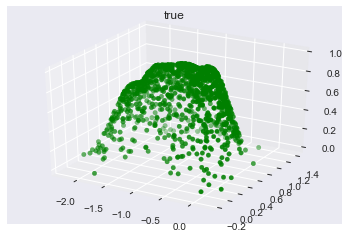

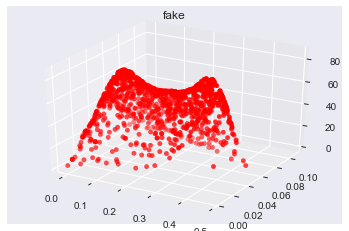

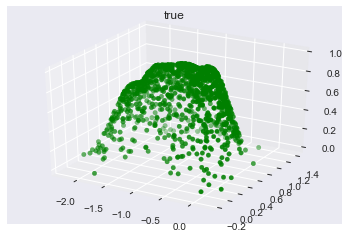

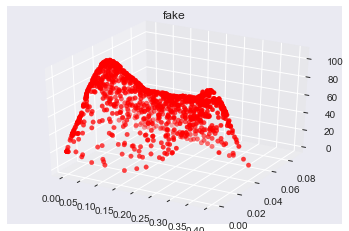

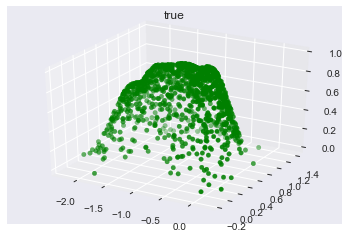

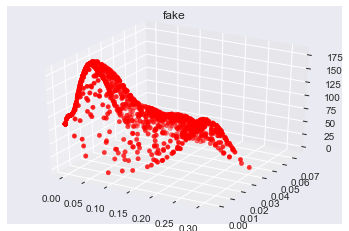

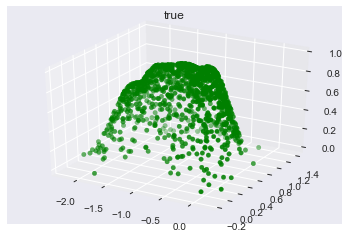

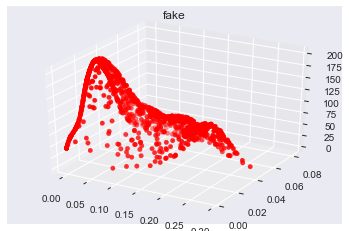

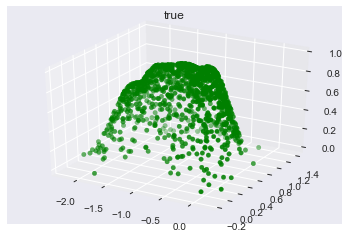

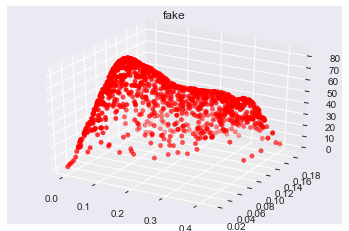

In [709]:
num_epochs = 1 

batch_size = 10

for phase in range(100):

    if phase%20 == 0:
        data1 = g_func(noise)
        plotting_func(X,Y,'green',title = "true")
        plotting_func(data1[:,0],data1[:,1],'red',title = "fake")
    
    discriminator1.input_layer = d_input
    
    for epoch in range(num_epochs):
    
        train_err = 0
        train_acc = 0
        train_batches = 0
    
        for batch in discriminator_iter(batch_size):
            inputs, target = batch
            d_train_func(inputs, target)
    

    discriminator1.input_layer = generator5
    for epoch in range(num_epochs):
        train_err = 0
        train_acc = 0
        train_batches = 0
        
        for batch in generator_iter(batch_size):
            inputs, target = batch
            g_train_func(inputs, target)